In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Computes the linear kernel between two vectors x and y
def linear_kernel(x, y):
    return np.dot(x, y)

# Computes the polynomial kernel of degree 2 between two vectors x and y
def polynomial_kernel(x, y):
    return (np.dot(x, y) + 1) ** 2

In [4]:
class SVM_SMO:
    # Initialize the SVM model with the given parameters
    # kernel (function): Kernel function to compute similarity between samples.
    # C (float or None): Regularization parameter. If None, assumes hard margin SVM.
    # tol (float): Tolerance for stopping criterion.
    # max_iter (int): Maximum number of iterations to perform during optimization.
    def __init__(self, kernel, C=None, tol=1e-3, max_iter=1000):
        self.kernel = kernel
        self.C = C
        self.tol = tol
        self.max_iter = max_iter

    # Train the SVM using the Sequential Minimal Optimization (SMO) algorithm.
    def fit(self, X, y):
        m, n = X.shape
        self.alpha = np.zeros(m) # Lagrange multipliers initialized to zero
        self.b = 0 # Intercept term
        self.X = X
        self.y = y

        # Precompute the kernel matrix for all pairs of training samples
        self.K = np.array([[self.kernel(X[i], X[j]) for j in range(m)] for i in range(m)])

        # Optimization loop
        for _ in range(self.max_iter):
            alpha_prev = np.copy(self.alpha) # Store the previous alpha values for convergence check
            for i in range(m):
                # Calculate the error for the i-th sample
                E_i = self._decision_function(X[i]) - y[i]
                # Check if the i-th alpha violates the KKT conditions
                if (y[i] * E_i < -self.tol and self.alpha[i] < (self.C if self.C else np.inf)) or \
                    (y[i] * E_i > self.tol and self.alpha[i] > 0):
                    # Randomly select a second index j not equal to i
                    j = self._select_j(i, m)
                    E_j = self._decision_function(X[j]) - y[j]

                    # Save the old alpha values for i and j
                    alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

                    # Compute the bounds L and H for the new alpha[j]
                    if y[i] != y[j]:
                        L = max(0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old) if self.C else np.inf
                    else:
                        L = max(0, alpha_j_old + alpha_i_old - self.C) if self.C else 0
                        H = min(self.C, alpha_j_old + alpha_i_old) if self.C else np.inf
                
                    if L == H: # Skip if L and H are the same
                        continue

                    # Compute eta, which is the second derivative of the objective function
                    eta = 2 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                    if eta >= 0: # Skip if eta is non-negative
                        continue

                    # Update alpha[j]
                    self.alpha[j] -= y[j] * (E_i - E_j) / eta
                    # Clip alpha[j] to the bounds [L, H]
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                
                if abs(self.alpha[j] - alpha_j_old) < 1e-5: # Skip if alpha[j] did not change significantly
                    continue

                # Update alpha[i] using the relationship between alpha[i] and alpha[j]
                self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])
                # Compute the intercept terms b1 and b2
                b1 = self.b - E_i - y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, i] - \
                     y[j] * (self.alpha[j] - alpha_j_old) * self.K[i, j]
                b2 = self.b - E_j - y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, j] - \
                     y[j] * (self.alpha[j] - alpha_j_old) * self.K[j, j]

                # Update the intercept b
                if self.C is None:  # Hard margin case
                    self.b = (b1 + b2) / 2
                else:  # Soft margin case
                    self.b = b1 if 0 < self.alpha[i] < self.C else b2 if 0 < self.alpha[j] < self.C else (b1 + b2) / 2

            # Check for convergence (if alpha values do not change significantly)
            if np.allclose(self.alpha, alpha_prev):
                break
 
    # Compute the decision function value for a given sample x
    def _decision_function(self, x):
        return np.sum(self.alpha * self.y * np.array([self.kernel(x, xi) for xi in self.X])) + self.b

    # Predict the class labels for the given samples.
    def predict(self, X):
        return np.sign([self._decision_function(x) for x in X])

    # Randomly select an index j that is not equal to i.
    def _select_j(self, i, m):
        j = i
        while j == i: # Ensure j is different from i
            j = np.random.randint(0, m)
        return j

In [9]:
# Plot decision surfaces
def plot_decision_boundary(svm, X, y, title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
    Z = np.array([svm._decision_function(np.array([xi, yi])) for xi, yi in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

In [6]:
# Generate toy dataset
np.random.seed(42)
X_train = np.random.randn(20, 2)
y_train = np.where(X_train[:, 0] + X_train[:, 1] > 0, 1, -1)

X_test = np.random.randn(10, 2)
y_test = np.where(X_test[:, 0] + X_test[:, 1] > 0, 1, -1)

In [7]:
# Train SVM using linear kernel
svm_linear = SVM_SMO(kernel=linear_kernel)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

In [8]:
# Train SVM using polynomial kernel
svm_poly = SVM_SMO(kernel=polynomial_kernel)
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)

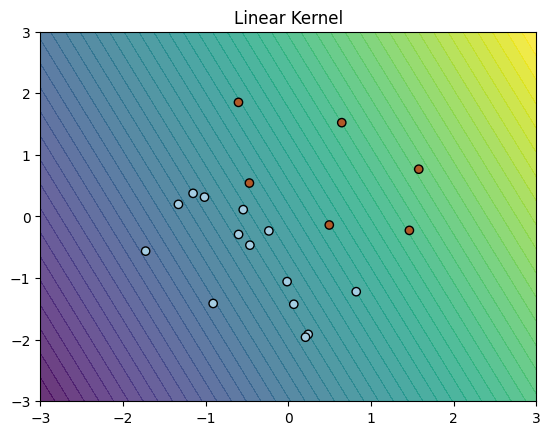

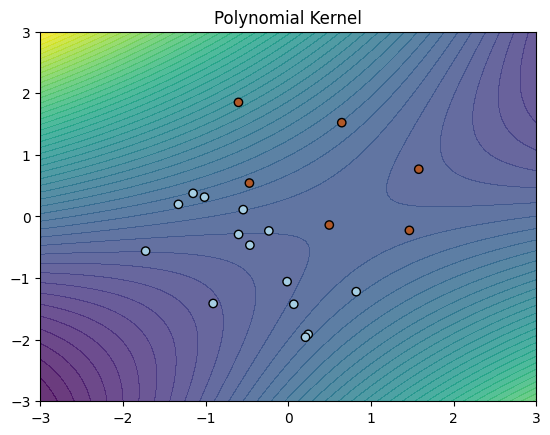

In [10]:
plot_decision_boundary(svm_linear, X_train, y_train, "Linear Kernel")
plot_decision_boundary(svm_poly, X_train, y_train, "Polynomial Kernel")

In [11]:
# Confusion Matrices
cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_poly = confusion_matrix(y_test, y_pred_poly)

Confusion Matrix (Linear Kernel):


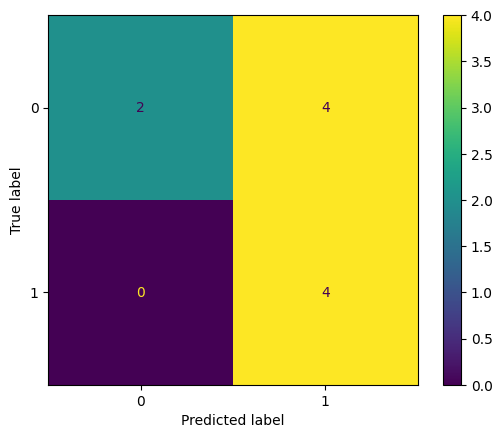

In [12]:
print("Confusion Matrix (Linear Kernel):")
ConfusionMatrixDisplay(cm_linear).plot()
plt.show()

Confusion Matrix (Polynomial Kernel):


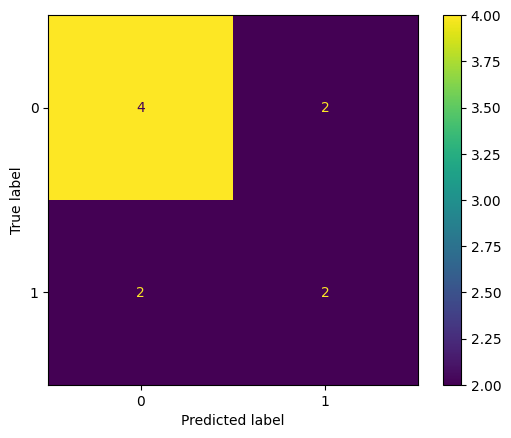

In [13]:
print("Confusion Matrix (Polynomial Kernel):")
ConfusionMatrixDisplay(cm_poly).plot()
plt.show()